## Load the data 

In [1]:
using HTTP, DataFrames, CSV
urlPrefix = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
global_confirmedFile =  "time_series_covid19_confirmed_global.csv"
global_deathsFile = "time_series_covid19_deaths_global.csv"
global_recoveredFile = "time_series_covid19_recovered_global.csv"

# function used to make the raw data as a dataframe
makeDF(url) = CSV.read(IOBuffer(String((HTTP.get(url)).body)));

In [2]:
# load the global confirmed/deaths/recovered cases data 
global_confirmedDF = makeDF(urlPrefix*global_confirmedFile);
global_deathsDF = makeDF(urlPrefix*global_deathsFile);
global_recoveredDF = makeDF(urlPrefix*global_recoveredFile);

In [3]:
# function used to get Province/State, Country/Region these two column renamed
function cleanNames(df)
    rename!(df,Symbol("Province/State")=>:ProvinceOrState)
    rename!(df,Symbol("Country/Region")=>:CountryOrRegion)
    
    numDays = size(df)[2]-4 
    #first four fields are :ProvinceOrState, :CountryOrRegion, :Lat, :Long
    #first date is 1/22/20
    for i in 1:numDays
        rename!(df,names(df)[4+i]=>"day$i")
    end
end

# use the cleanNames() function to get Province/State, Country/Region in each dataframe renamed
cleanNames(global_confirmedDF)
cleanNames(global_deathsDF)
cleanNames(global_recoveredDF)

In [4]:
#This function can be used for country data
#type is :confirmed, :deaths or :recovered
function countryData(country,dfType; sumProvinces = true)
    if dfType == :confirmed
        df = global_confirmedDF
    elseif dfType == :deaths
        df = global_deathsDF
    elseif dfType == :recovered
        df = global_recoveredDF
    else
        println("error")
    end
    dataMatrix = convert(Array{Int},df[df.CountryOrRegion .== country,5:end])
    if size(dataMatrix)[1] == 0
        println("error data country not found")
    end
    if sumProvinces
        return sum(dataMatrix,dims=1)[1,:]
    else
        return dataMatrix[1,:]
    end
end

countryData (generic function with 1 method)

### global_confirmedDF

Firstly, let's take a look at the "global_confirmedDF" to see which countries data is collected.

In [43]:
# drop missing value: if the value in CountryOrRegion column is missing, we drop this record
global_confirmedDF = dropmissing(global_confirmedDF, :CountryOrRegion);

In [45]:
unique(global_confirmedDF.CountryOrRegion)

188-element Array{String,1}:
 "Afghanistan"
 "Albania"
 "Algeria"
 "Andorra"
 "Angola"
 "Antigua and Barbuda"
 "Argentina"
 "Armenia"
 "Australia"
 "Austria"
 "Azerbaijan"
 "Bahamas"
 "Bahrain"
 ⋮
 "Ukraine"
 "United Arab Emirates"
 "United Kingdom"
 "Uruguay"
 "Uzbekistan"
 "Venezuela"
 "Vietnam"
 "West Bank and Gaza"
 "Western Sahara"
 "Yemen"
 "Zambia"
 "Zimbabwe"

From the output above, we can see that there are about 200 countries/regions contained in the dataset. 
There are aroud 200 countries in the world today, so the covid-19 has spread all over the world, which has a wider impact than SARS and MERS. 

In [46]:
global_confirmed_country_level = global_confirmedDF[:, [1,2,3,4,end]];

# firstly, group by the global_confirmedDF by CountryOrRegion Column
# then, combine the grouped dataframe by suming up the last column (latest number of confirmed cases)
# finally sort it by descend order

global_confirmed_country_level = groupby(global_confirmed_country_level,:CountryOrRegion; sort=false, skipmissing=false);
global_confirmed_country_level = combine(global_confirmed_country_level, [:5] => sum);
global_confirmed_country_level = sort!(global_confirmed_country_level, [:2], rev = true);
global_confirmed_country_level = names!(global_confirmed_country_level, [:CountryOrRegion, :total_confirmed])

,CountryOrRegion,total_confirmed
,String,Int64
1,US,5961094
2,Brazil,3846153
3,India,3542733
4,Russia,982573
5,Peru,629961
6,South Africa,622551
7,Colombia,599884
8,Mexico,591712
9,Spain,439286


According to the output above, we can see that the top 5 countries with most confirmed cases are US, Brazil, India, Russia and Peru.

In [47]:
# total number of confirmed cases worldwide
total_confirmed = sum(global_confirmed_country_level.total_confirmed);

# a dataframe of top 5 countries with most confirmed cases 
top5_confirmed = global_confirmed_country_level[1:5, :];
top5_confirmed.confirmed_proportion = top5_confirmed[:, 2] ./ total_confirmed;


world_confirmed = copy(top5_confirmed)

,CountryOrRegion,total_confirmed,confirmed_proportion
,String,Int64,Float64
1,US,5961094,0.238478
2,Brazil,3846153,0.153868
3,India,3542733,0.141729
4,Russia,982573,0.0393085
5,Peru,629961,0.025202


In [48]:
# add a new record which contains the total number of confirmed cases from other countries (except for top 5 countries), and 
# the proportion of its cumulative confirmed cases to the global cumulative confirmed cases
total_other_confirmed = total_confirmed - sum(top5_confirmed.total_confirmed);
push!(world_confirmed, ["Other Countries" total_other_confirmed total_other_confirmed/total_confirmed])

,CountryOrRegion,total_confirmed,confirmed_proportion
,String,Int64,Float64
1,US,5961094,0.238478
2,Brazil,3846153,0.153868
3,India,3542733,0.141729
4,Russia,982573,0.0393085
5,Peru,629961,0.025202
6,Other Countries,10033942,0.401415


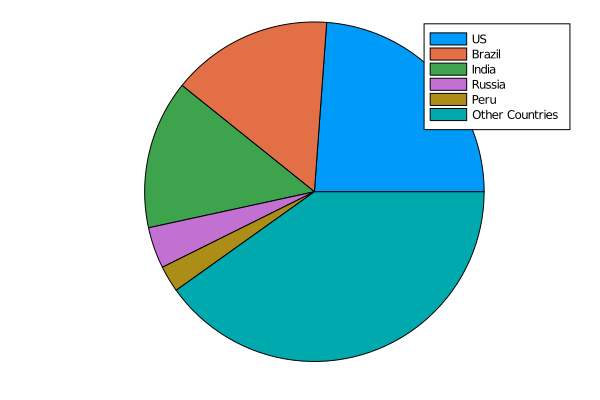

In [49]:
using Plots
labels = world_confirmed[:, 1];
sizes = world_confirmed[:, ncol(world_confirmed)];
pie(labels, sizes)

### global_recoveredDF

In [35]:
# drop missing value: if the value in CountryOrRegion column is missing, we drop this record
global_recoveredDF = dropmissing(global_recoveredDF, :CountryOrRegion);

In [50]:
global_recovered_country_level = global_recoveredDF[:, [1,2,3,4,end]];

# firstly, group by the global_recoveredDF by CountryOrRegion Column
# then, combine the grouped dataframe by suming up the last column (latest number of recovered cases)
# finally sort it by descend order

global_recovered_country_level = groupby(global_recovered_country_level,:CountryOrRegion; sort=false, skipmissing=false);
global_recovered_country_level = combine(global_recovered_country_level, [:5] => sum);
global_recovered_country_level = sort!(global_recovered_country_level, [:2], rev = true);
global_recovered_country_level = names!(global_recovered_country_level, [:CountryOrRegion, :total_recovered])

,CountryOrRegion,total_recovered
,String,Int64
1,Brazil,3202185
2,India,2713933
3,US,2140614
4,Russia,802365
5,South Africa,536694
6,Mexico,484283
7,Colombia,440562
8,Peru,438017
9,Chile,381183


According to the table above, we can know that the top 5 countries with the most recovered cases are Brazil, India, US, Russia and South Africa. However, the reason why some countries have a large number of recovered cases is that they have relatively large number of confirmed cases.

<br>
Because of this fact, we better take a look at the cure rate of covid-19 in each country to evaluate the level of treatment. 

In [51]:
global_recovered_country_level = leftjoin(global_recovered_country_level, 
                                          global_confirmed_country_level, 
                                          on = :CountryOrRegion);

global_recovered_country_level.cure_proportion = global_recovered_country_level[:, 2] ./ global_recovered_country_level[:, 3];

global_recovered_country_level = sort!(global_recovered_country_level, :cure_proportion, rev = true)

,CountryOrRegion,total_recovered,total_confirmed,cure_proportion
,String,Int64,Int64?,Float64
1,Luxembourg,7140,6625,1.07774
2,Grenada,24,24,1.0
3,Saint Kitts and Nevis,17,17,1.0
4,Holy See,12,12,1.0
5,Djibouti,5314,5385,0.986815
6,Belarus,70207,71523,0.9816
7,Mongolia,295,301,0.980066
8,Singapore,55447,56717,0.977608
9,Qatar,115251,118407,0.973346


From the table above, we can notice that the cure rate of Luxembourg is over 1.0, which is unreasonable. I think there may be some problems in the data collection process. Apart from Luxembourg, the cure rate of Grenada, Saint Kitts and Nevis, Holy See are all equal to 1.0. However, the number of confirmed cases in these 3 countries/regions are 24, 17 and 12 respectively, which are not many. Therefore, it could be much possible for them to have a high cure rate.

Next, I would like to do some query to see which countries/regions with more than 50,000 confirmed cases have relatively high fatality rates. 

In [52]:
using Query

q1 = @from i in global_recovered_country_level begin
     @where i.total_confirmed > 50000
     @select {i.CountryOrRegion, i.total_recovered, i.total_confirmed, i.cure_proportion}
     @collect DataFrame
end


,CountryOrRegion,total_recovered,total_confirmed,cure_proportion
,String,Int64,Int64?,Float64
1,Belarus,70207,71523,0.9816
2,Singapore,55447,56717,0.977608
3,Qatar,115251,118407,0.973346
4,Pakistan,280340,295372,0.949108
5,China,84484,89863,0.940142
6,Bahrain,48275,51391,0.939367
7,Oman,79608,85005,0.93651
8,Chile,381183,408009,0.934251
9,Saudi Arabia,288441,313911,0.918862


It can be seen from the output above that Belarus, Singapore, Qatar, Pakistan and China are top 5 countries ( with over 50,000 confirmed cases) have relatively high cure rate.

### global_deathsDF

In [53]:
# drop missing value: if the value in CountryOrRegion column is missing, we drop this record
global_deathsDF = dropmissing(global_deathsDF, :CountryOrRegion);

In [54]:
global_deaths_country_level = global_deathsDF[:, [1,2,3,4,end]];

# firstly, group by the global_deathsDF by CountryOrRegion Column
# then, combine the grouped dataframe by suming up the last column (latest number of dead cases)
# finally sort it by descend order

global_deaths_country_level = groupby(global_deaths_country_level,:CountryOrRegion; sort=false, skipmissing=false);
global_deaths_country_level = combine(global_deaths_country_level, [:5] => sum);
global_deaths_country_level = sort!(global_deaths_country_level, [:2], rev = true);
global_deaths_country_level = names!(global_deaths_country_level, [:CountryOrRegion, :total_deaths])

,CountryOrRegion,total_deaths
,String,Int64
1,US,182761
2,Brazil,120262
3,Mexico,63819
4,India,63498
5,United Kingdom,41585
6,Italy,35473
7,France,30601
8,Spain,29011
9,Peru,28471


According to the table above, we can know that the top 5 countries with the most dead cases are US, Brazil, Mexicao, India, and United Kingdom. However, the reason why these countries have a large number of dead cases is that they have relatively large number of confirmed cases.


Because of this fact, we better take a look at the case fatality rate of covid-19 in each country to evaluate the level of treatment.

In [55]:
global_deaths_country_level = leftjoin(global_deaths_country_level, 
                                          global_confirmed_country_level, 
                                          on = :CountryOrRegion);

global_deaths_country_level.death_proportion = global_deaths_country_level[:, 2] ./ global_deaths_country_level[:, 3];

global_deaths_country_level = sort!(global_deaths_country_level, :death_proportion, rev = true)

,CountryOrRegion,total_deaths,total_confirmed,death_proportion
,String,Int64,Int64?,Float64
1,Yemen,563,1946,0.289311
2,MS Zaandam,2,9,0.222222
3,Italy,35473,266853,0.132931
4,United Kingdom,41585,334916,0.124165
5,Belgium,9891,84599,0.116916
6,Hungary,614,5669,0.108308
7,Mexico,63819,591712,0.107855
8,France,30601,304947,0.100349
9,Western Sahara,1,10,0.1


Next, I want to find out which countries with more than 50,000 confirmed cases have relatively high fatality rates.

In [56]:
q2 = @from i in global_deaths_country_level begin
     @where i.total_confirmed > 50000
     @select {i.CountryOrRegion, i.total_deaths, i.total_confirmed, i.death_proportion}
     @collect DataFrame
end

,CountryOrRegion,total_deaths,total_confirmed,death_proportion
,String,Int64,Int64?,Float64
1,Italy,35473,266853,0.132931
2,United Kingdom,41585,334916,0.124165
3,Belgium,9891,84599,0.116916
4,Mexico,63819,591712,0.107855
5,France,30601,304947,0.100349
6,Netherlands,6252,72128,0.0866792
7,Canada,9161,129639,0.0706655
8,Sweden,5821,83958,0.0693323
9,Spain,29011,439286,0.0660413


We can see that many European countries have relatively high fatality rates.

## The trend of confirmed cases in some "important" countries 

### China

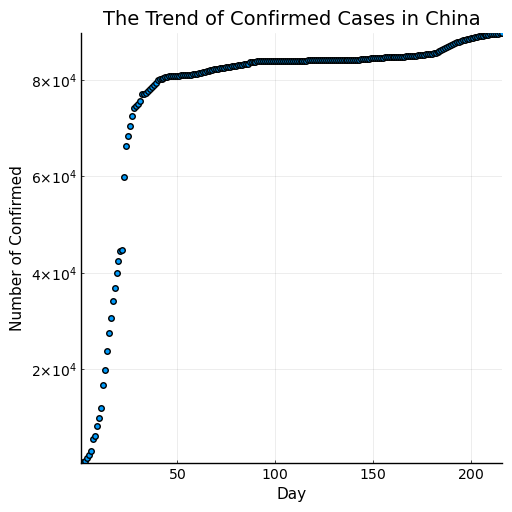

┌ Info: Saved animation to 
│   fn = C:\Users\Xuerong Wang\tmp.gif
└ @ Plots C:\Users\Xuerong Wang\.julia\packages\Plots\6RLiv\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Xuerong Wang\\tmp.gif")
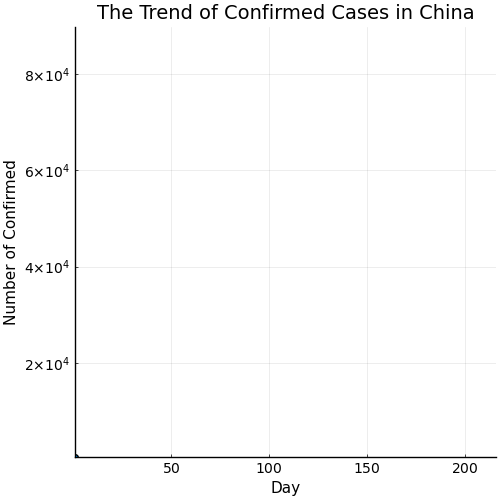

In [12]:
using Plots
china_data = countryData("China", :confirmed, sumProvinces = true)
len_data = size(china_data)[1]
x = collect(1:1:len_data)


pyplot(size=(500,500), xtickfontsize=10, ytickfontsize=10, xaxis = "Day", yaxis = "Number of Confirmed", title = "The Trend of Confirmed Cases in China", leg = false)
p = scatter(1, xlim=extrema(x), ylim=extrema(china_data))

@gif for xi in x
    push!(p, 1, xi, china_data[xi])
end

### Europe

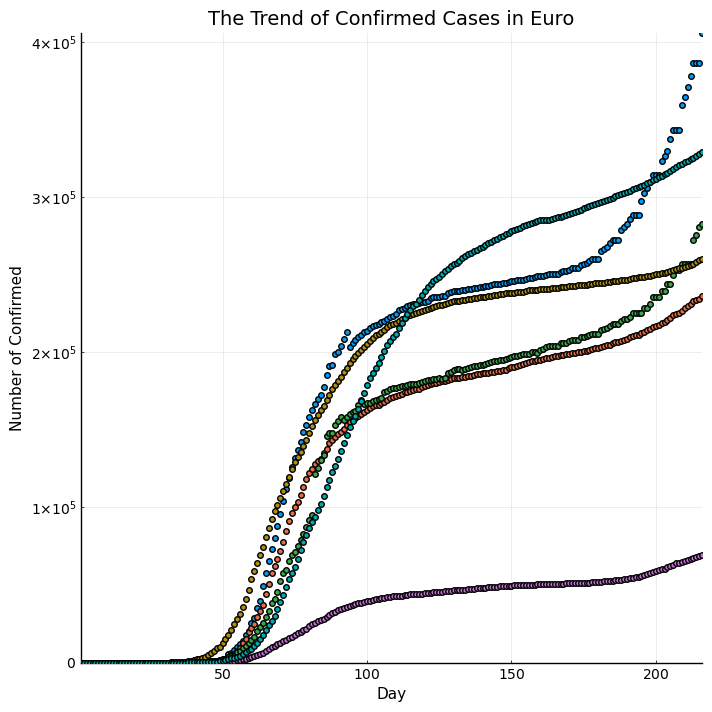

┌ Info: Saved animation to 
│   fn = C:\Users\Xuerong Wang\tmp.gif
└ @ Plots C:\Users\Xuerong Wang\.julia\packages\Plots\6RLiv\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Xuerong Wang\\tmp.gif")
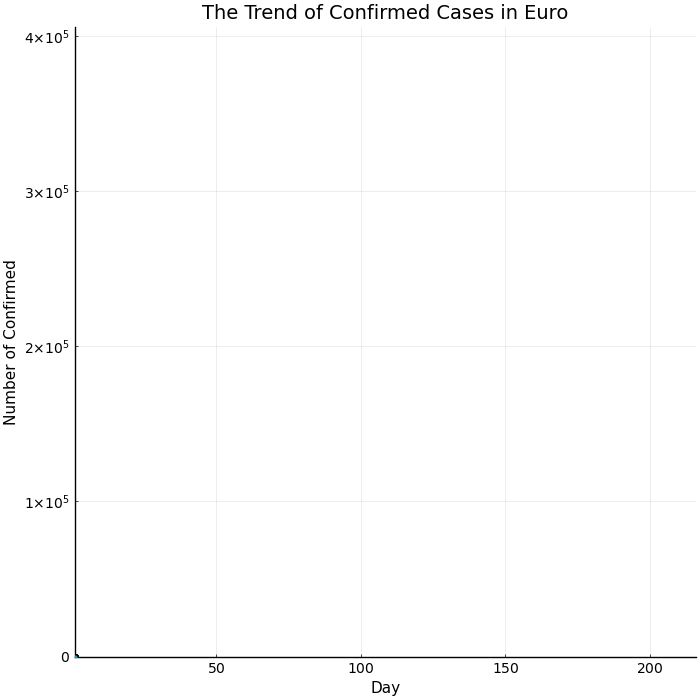

In [13]:
euro_countries = ["Spain","Germany","France","Netherlands","Italy","United Kingdom"]
euro_data = hcat(countryData.(euro_countries,:confirmed,sumProvinces = true)...)


pyplot(size=(700,700), xtickfontsize=10, ytickfontsize=10, xaxis = "Day", yaxis = "Number of Confirmed", 
    title = "The Trend of Confirmed Cases in Euro", markersize = 4, legend = true)
p = scatter(6, xlim=extrema(x), ylim=extrema(euro_data));

@gif for xi in x
    push!(p,euro_data[xi,:])
end

### America

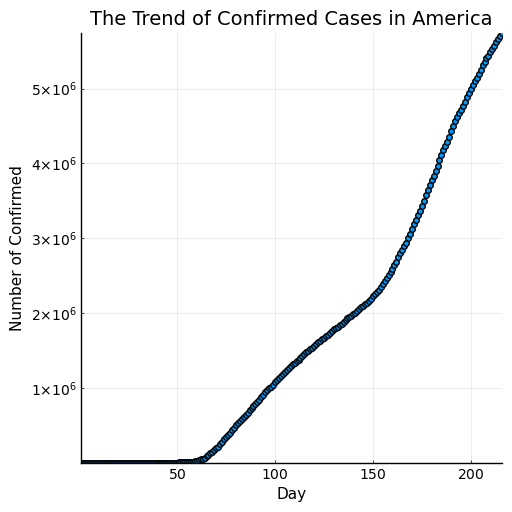

┌ Info: Saved animation to 
│   fn = C:\Users\Xuerong Wang\tmp.gif
└ @ Plots C:\Users\Xuerong Wang\.julia\packages\Plots\6RLiv\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Xuerong Wang\\tmp.gif")
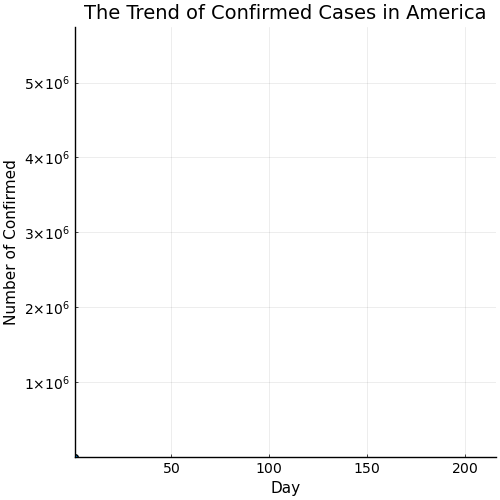

In [11]:
usa_data = countryData("US", :confirmed, sumProvinces = true)

pyplot(size=(500, 500), xtickfontsize=10, ytickfontsize=10, xaxis = ("Day"), yaxis = "Number of Confirmed", title = "The Trend of Confirmed Cases in America", leg = false)
p = scatter(1, xlim=extrema(x), ylim=extrema(usa_data));

@gif for xi in x
    push!(p, 1, xi, usa_data[xi])
end